### Noelle Landauer
### CIS 277A, Lab7, 11/16/22 

## Bumblebee incidence in Oregon, part II

Original sources of [2018](https://www.gbif.org/dataset/b2974853-6c41-4c63-a11b-7989e58a3ad4) and [2019](https://www.gbif.org/dataset/3301620d-6750-434e-97ad-abfac165bb9c) data

Forst. let's load the data from last week, reset the index, and replace Bombus bifarius with Bombus vancouverensis:

In [1]:
import pandas as pd
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bombus18 = pd.read_excel(r".\Bombus2018.xlsx")
bombus19 = pd.read_excel(r".\Bombus2019.xlsx")
all_bombus = pd.concat([bombus18, bombus19], ignore_index=True)
all_bombus = all_bombus.dropna()
all_bombus.set_index('gbifID', inplace=True)
all_bombus = all_bombus.replace(to_replace='Bombus bifarius', value='Bombus vancouverensis')

In [3]:
bombus_species = all_bombus['species'].value_counts()
bombus_species

Bombus vosnesenskii      1228
Bombus vancouverensis     860
Bombus mixtus             624
Bombus fervidus           381
Bombus flavifrons         309
Bombus centralis          293
Bombus melanopygus        192
Bombus huntii             171
Bombus caliginosus        163
Bombus griseocollis       140
Bombus flavidus           113
Bombus vandykei            95
Bombus sitkensis           90
Bombus rufocinctus         61
Bombus appositus           58
Bombus nevadensis          53
Bombus insularis           45
Bombus morrisoni           30
Bombus occidentalis        28
Bombus sylvicola           25
Bombus vagans               5
Name: species, dtype: int64

Let's plot this again with a bar plot, using Seaborn this time. 

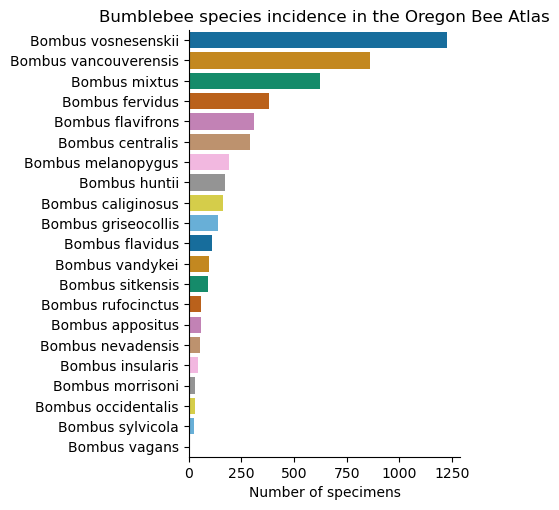

In [4]:
species_bar = sns.catplot(data=all_bombus, 
                          kind='count', 
                          y='species', 
                          order=all_bombus['species'].value_counts().index,
                          palette='colorblind')
species_bar.set(title='Bumblebee species incidence in the Oregon Bee Atlas',
                xlabel='Number of specimens', 
                ylabel=None)

Next, let's take a look at the seasonal incidence for the most common species. Bumblebee colonies have an annual lifecycle which start with a single queen, build a population of sterile female workers, and peak with the production of males and new queens.  The question is, do different species of bumblebees have distinct seasons, or do they all persist so long as weather is warm enough to fly? To start, I will just look at most common five species.

In [5]:
top5list = ['Bombus vosnesenskii','Bombus vancouverensis','Bombus mixtus','Bombus fervidus','Bombus flavifrons']
top5_df = all_bombus.query('species in @top5list')

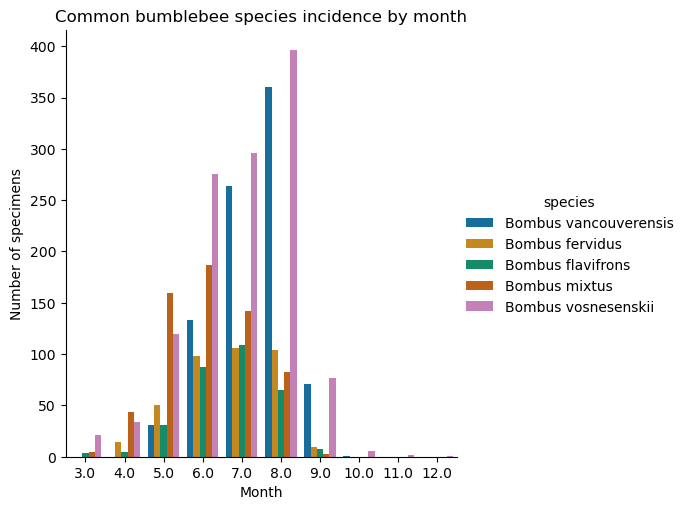

In [6]:
top5_month_bar = sns.catplot(data=top5_df, 
                          kind='count', 
                          x='month',
                             hue='species',
                          palette='colorblind')
top5_month_bar.set(title='Common bumblebee species incidence by month',
                xlabel='Month', 
                ylabel='Number of specimens')

This sort of gets at what we are looking for, but it is messy. The higher absolute numbers of the top 2 species (vosnesenskii & vancouverensis) may be driving their spikes the later months. What we want is a relative measure of their numbers, so let's look at a KDE plot: 

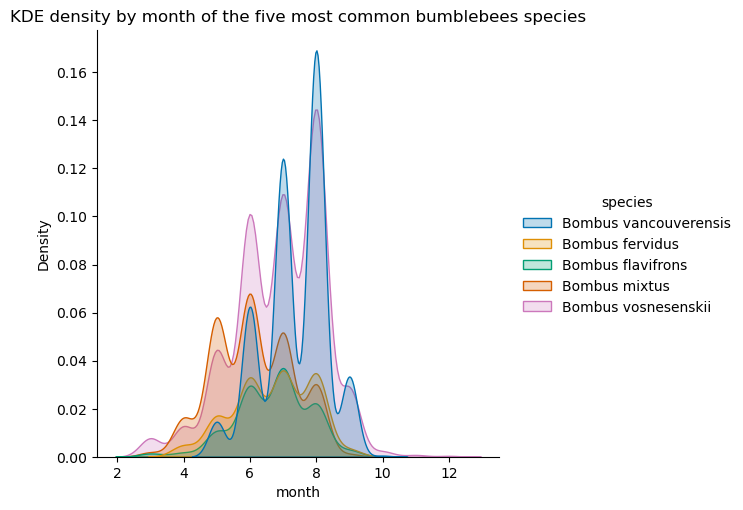

In [7]:
top5_month_kde = sns.displot(data=top5_df, 
                             kind='kde', 
                             x='month', 
                             hue='species', 
                             fill=True, 
                             palette='colorblind')
top5_month_kde.set(title='KDE density by month of the five most common bumblebees species')

Still weird, because month really isn't a continuous measure. Also "density" is a difficult measure to interpret. But we can begin to see that fervidus and mixtus are biased towards the spring, vancouverensis and vosnesenskii tend to be found later in the summer, and flavifrons is right in the middle.

Finally, save the plots to files:

In [8]:
species_bar.savefig('bombus_species_bar.png')
top5_month_bar.savefig('top5species_month_bar.png')
top5_month_kde.savefig('top5species_month_kde.svg')

## Relationship between ratings and number of votes for IMDB movies, part II

This week, let's look at a direct correlation between average ratings and number of votes among IMDB movies. For this I don't want to limit the search to movies with at least 5000 votes, as movies with lower number of votes are a valid part of the correlation. I will limit it to non-adult movies with a runtime of at least 60 minutes, to avoid short films with extremely limited release. This results in a dataset of 150K rows, so it takes a few seconds to run.

In [9]:
connection = pyodbc.connect(
    server="cisdbss.pcc.edu",
    user="275student",
    password="275student",
    database="IMDB",
    driver="{ODBC Driver 17 for SQL Server}")

In [10]:
sql = '''SELECT primaryTitle, tb.tconst, startYear, averageRating, numVotes
FROM title_basics tb
JOIN title_ratings tr ON tb.tconst=tr.tconst
WHERE titleType = 'movie'
AND numVotes >= 10
AND isAdult = 0
AND runtimeMinutes >= 60'''

In [11]:
movie_ratings = pd.read_sql_query(sql, connection)

C:\Users\noell\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Add in the rough year groups and ratings quintiles from last week as well:

In [12]:
year_bins = [1905, 1960, 1990, 2018]
movie_ratings['YearGroup'] = pd.cut(movie_ratings['startYear'], 
                                    bins=year_bins, 
                                    labels=['Premodern', 'Early Modern', 'IMDB Era'])
movie_ratings['numVotesQuintiles'] = pd.qcut(movie_ratings['numVotes'], q=5)
movie_ratings

,primaryTitle,tconst,startYear,averageRating,numVotes,YearGroup,numVotesQuintiles
0,The Story of the Kelly Gang,tt0000574,1906.0,6.3,431,Premodern,"(174.0, 745.0]"
1,The Fairylogue and Radio-Plays,tt0000679,1908.0,6.1,24,Premodern,"(23.0, 59.0]"
2,Dante's Inferno,tt0002130,1911.0,7.1,1538,Premodern,"(745.0, 1914584.0]"
3,"From the Manger to the Cross; or, Jesus of Naz...",tt0002199,1912.0,5.8,388,Premodern,"(174.0, 745.0]"
4,Madame DuBarry,tt0002423,1919.0,6.9,597,Premodern,"(174.0, 745.0]"
...,...,...,...,...,...,...,...
150165,Eiffel I'm in Love 2,tt7946644,2018.0,7.4,29,IMDB Era,"(23.0, 59.0]"
150166,The Foundation of Criminal Excellence,tt7953814,2018.0,8.6,229,IMDB Era,"(174.0, 745.0]"
150167,Cin Çesmesi,tt7960918,2018.0,4.8,18,IMDB Era,"(9.999, 23.0]"
150168,Till the End of the World,tt7962598,2018.0,7.2,28,IMDB Era,"(23.0, 59.0]"


First, lets look at the correlation between average rating and number of votes, regardless of year:

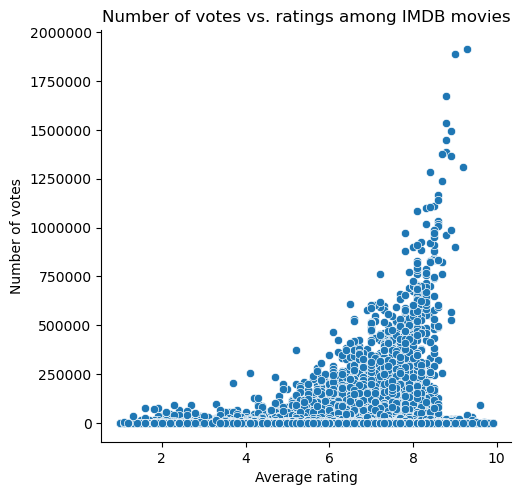

In [13]:
rating_votes_scatter = sns.relplot(data=movie_ratings, 
                                   kind='scatter',
                                   x='averageRating', 
                                   y='numVotes')
rating_votes_scatter.set(title='Number of votes vs. ratings among IMDB movies',
                        xlabel='Average rating',
                        ylabel='Number of votes')
plt.ticklabel_format(style='plain', axis='y')

It looks like a rough correlation, but one driven by a few number of highly rated, highly voted on movies. What if we color-code by the year category?

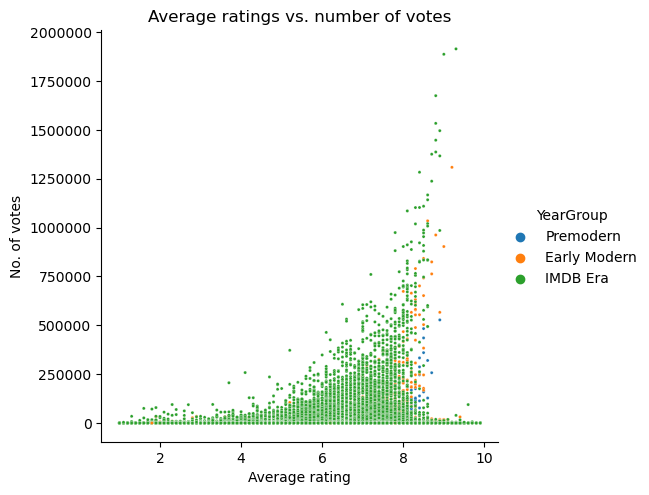

In [14]:
rating_votes_era_scatter = sns.relplot(data=movie_ratings, 
                                   kind='scatter',
                                   x='averageRating', 
                                   y='numVotes',
                                       hue='YearGroup',
                                      s=5)
rating_votes_era_scatter.set(title='Average ratings vs. number of votes',
                             xlabel='Average rating',
                             ylabel='No. of votes')
plt.ticklabel_format(style='plain', axis='y')

The plot is overwhelmed by modern movies, and is also driven by a large number of movies with very few votes, and a small number of movies at the top with very high number of votes. I think the quintile approach from last week works best with this range of data. This is a similar graph with the bigger dataset, only with an enhanced box plot showing the tremendous range:

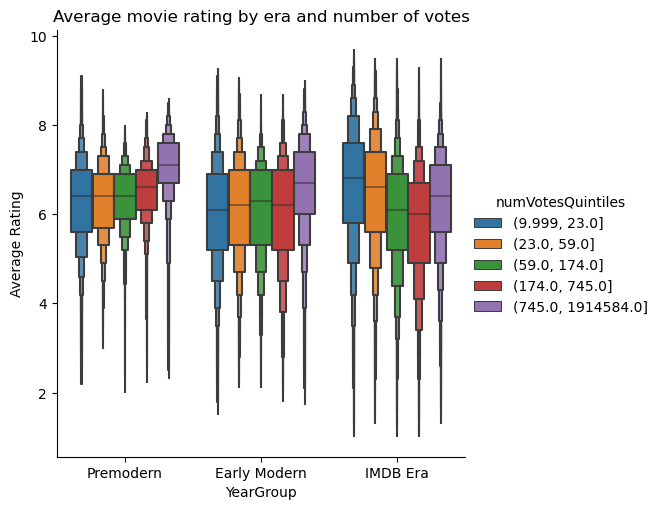

In [15]:
ratings_bin_boxen = sns.catplot(data=movie_ratings, 
                                  kind='boxen', 
                                  x='YearGroup', 
                                  y='averageRating', 
                                  hue='numVotesQuintiles',
                                 showfliers=False)
ratings_bin_boxen.set(title='Average movie rating by era and number of votes',
                     ylabel='Average Rating')

The less ambigous pattern from last week, where newer movies had lower ratings, is now mostly gone, although the most well-voted older movies still hav=d high ratings within their group. From the legend here one can see than 80% of movies had fewer than 745 votes. The pattern only applied when considering the movies with the highest number of votes. 

Finally, save the remaining plots to file:

In [16]:
rating_votes_scatter.savefig('rating_votes_scatter.png')
rating_votes_era_scatter.savefig('rating_vote.era_scatter.png')
ratings_bin_boxen.savefig('ratings_boxen_quint.svg')